In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc


# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches
from scipy import stats
from scipy.stats import skew

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 100)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os,random, math, psutil, pickle
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

# Reading and understanding our data

In [3]:
building_meta_df = pd.read_csv('energyCSV/building_metadata.csv')
test_df = pd.read_csv('energyCSV/test.csv')
train_df = pd.read_csv('energyCSV/train.csv')
weather_test_df = pd.read_csv('energyCSV/weather_test.csv')
weather_train_df = pd.read_csv('energyCSV/weather_train.csv')
sample_submission = pd.read_csv('energyCSV/sample_submission.csv')

train_df

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575


In [4]:
print('Size of train_df data', train_df.shape)
print('Size of weather_train_df data', weather_train_df.shape)
print('Size of weather_test_df data', weather_test_df.shape)
print('Size of building_meta_df data', building_meta_df.shape)

Size of train_df data (20216100, 4)
Size of weather_train_df data (139773, 9)
Size of weather_test_df data (277243, 9)
Size of building_meta_df data (1449, 6)


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


# Reduce The Memory For Faster Processing

In [6]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int16  
 1   meter          int8   
 2   timestamp      object 
 3   meter_reading  float32
dtypes: float32(1), int16(1), int8(1), object(1)
memory usage: 289.2+ MB


In [9]:
building_meta_df

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN




Features that are likely predictive:

Buildings

    primary_use
    square_feet
    year_built
    floor_count (may be too sparse to use)

Weather

    time of day
    holiday
    weekend
    cloud_coverage + lags
    dew_temperature + lags
    precip_depth + lags
    sea_level_pressure + lags
    wind_direction + lags
    wind_speed + lags

Train

    max, mean, min, std of the specific building historically
    number of meters
    number of buildings at a siteid



**Converting "timestamps" To datetime And String To Category Datatype**

*Categoricals are a pandas data type corresponding to categorical variables in statistics. A categorical variable takes on a limited, and usually fixed, number of possible values*

In [10]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

#building_meta_df['primary_use'] = building_meta_df['primary_use'].astype('category')

In [11]:
train_df["hour"] = train_df["timestamp"].dt.hour
train_df["day"] = train_df["timestamp"].dt.day
train_df["weekend"] = train_df["timestamp"].dt.weekday
train_df["month"] = train_df["timestamp"].dt.month

test_df["hour"] = test_df["timestamp"].dt.hour
test_df["day"] = test_df["timestamp"].dt.day
test_df["weekend"] = test_df["timestamp"].dt.weekday
test_df["month"] = test_df["timestamp"].dt.month

# Merging the features of building_meta_df with train_df and test_df

In [12]:
temp_df = train_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']
test_df = pd.concat([test_df, temp_df], axis=1)

del temp_df, building_meta_df

# Merging the features of weather_df with train_df and test_df

In [13]:
temp_df = train_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_train_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_test_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
test_df = pd.concat([test_df, temp_df], axis=1)

del temp_df, weather_train_df, weather_test_df

**Storing train_df and test_df using to_pickle**

*to_pickle(): A good solution for keeping that dataframe constantly available in between runs so I don't have to spend all that time waiting for the script to run*

*gc.collect() : It performs a blocking garbage collection of all generations. All objects, regardless of how long they have been in memory, are considered for collection; however, objects that are referenced in managed code are not collected. Use this method to force the system to try to reclaim the maximum amount of available memory.*

In [14]:
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')
   
del train_df, test_df
gc.collect()

20

In [15]:
train_df = pd.read_pickle('train_df.pkl')
test_df = pd.read_pickle('test_df.pkl')

train_df

,building_id,meter,timestamp,meter_reading,hour,day,weekend,month,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,Education,7432,2008.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,Education,2720,2004.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,Education,5376,1991.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,Education,23685,2002.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,Education,116607,1975.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,23,31,5,12,15,Entertainment/public assembly,19619,1914.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,23,31,5,12,15,Education,4298,NaN,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,23,31,5,12,15,Entertainment/public assembly,11265,1997.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,23,31,5,12,15,Lodging/residential,29775,2001.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


# Featuring Engineering

**Encoding**

In [16]:
le = LabelEncoder()

train_df['primary_use'] = le.fit_transform(train_df['primary_use']).astype(np.int8)

test_df['primary_use'] = le.fit_transform(test_df['primary_use']).astype(np.int8)

**Calculating The Age**

In [17]:
#train_df['age'] = train_df['year_built'].max() - train_df['year_built'] + 1
#test_df['age'] = test_df['year_built'].max() - test_df['year_built'] + 1

**Find the optimal feature subset using an evaluation measure. The choice of evaluation metric distinguish the three main strategies of feature selection algorithms: the wrapper strategy, the filter strategy, and the embedded strategy.**

Filter methods:

    information gain
    chi-square test
    correlation coefficient
    variance threshold
    
    
Wrapper methods:

    recursive feature elimination
    sequential feature selection algorithms
    
    
Embedded methods:

    L1 (LASSO) regularization
    decision tree

In [18]:
train_df

,building_id,meter,timestamp,meter_reading,hour,day,weekend,month,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,0,7432,2008.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,0,2720,2004.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,0,5376,1991.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,0,23685,2002.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,1,4,1,0,0,116607,1975.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,23,31,5,12,15,1,19619,1914.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,23,31,5,12,15,0,4298,NaN,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,23,31,5,12,15,1,11265,1997.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,23,31,5,12,15,4,29775,2001.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


**Dropping Timestamps**

In [19]:
train_df = train_df.drop("timestamp", axis = 1)

In [20]:
test_df = test_df.drop("timestamp", axis = 1)

# Dealing With Cat,Num Features And Dropping Unnecessary Features

In [21]:
categoricals = ["building_id", "primary_use", "hour", "day", "weekend", "month", "meter"]

numericals = ["square_feet", "year_built", "air_temperature", "cloud_coverage","dew_temperature"]

In [22]:
drop_cols = ["precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed"]

In [23]:
train_df[categoricals + numericals]

,building_id,primary_use,hour,day,weekend,month,meter,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature
0,0,0,0,1,4,1,0,7432,2008.0,25.000000,6.0,20.000000
1,1,0,0,1,4,1,0,2720,2004.0,25.000000,6.0,20.000000
2,2,0,0,1,4,1,0,5376,1991.0,25.000000,6.0,20.000000
3,3,0,0,1,4,1,0,23685,2002.0,25.000000,6.0,20.000000
4,4,0,0,1,4,1,0,116607,1975.0,25.000000,6.0,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,1,23,31,5,12,0,19619,1914.0,1.700195,NaN,-5.601562
20216096,1445,0,23,31,5,12,0,4298,NaN,1.700195,NaN,-5.601562
20216097,1446,1,23,31,5,12,0,11265,1997.0,1.700195,NaN,-5.601562
20216098,1447,4,23,31,5,12,0,29775,2001.0,1.700195,NaN,-5.601562


In [24]:
test_df[categoricals + numericals]

,building_id,primary_use,hour,day,weekend,month,meter,square_feet,year_built,air_temperature,cloud_coverage,dew_temperature
0,0,0,0,1,6,1,0,7432,2008.0,17.796875,4.0,11.703125
1,1,0,0,1,6,1,0,2720,2004.0,17.796875,4.0,11.703125
2,2,0,0,1,6,1,0,5376,1991.0,17.796875,4.0,11.703125
3,3,0,0,1,6,1,0,23685,2002.0,17.796875,4.0,11.703125
4,4,0,0,1,6,1,0,116607,1975.0,17.796875,4.0,11.703125
...,...,...,...,...,...,...,...,...,...,...,...,...
41697595,1444,1,7,9,2,5,0,19619,1914.0,NaN,NaN,NaN
41697596,1445,0,7,9,2,5,0,4298,NaN,NaN,NaN,NaN
41697597,1446,1,7,9,2,5,0,11265,1997.0,NaN,NaN,NaN
41697598,1447,4,7,9,2,5,0,29775,2001.0,NaN,NaN,NaN


In [25]:
feat_cols = categoricals + numericals

In [26]:
train_df.shape

(20216100, 19)

In [27]:
test_df.shape

(41697600, 19)

In [28]:
#plotting 100 highest consuming buildings
#import matplotlib.pyplot as plt
#top_buildings = train_df.groupby("building_id")["meter_reading"].mean().sort_values(ascending = False).iloc[:100]

#for value in top_buildings.index:
#    train_df[train_df["building_id"] == value]["meter_reading"].rolling(window = 24).mean().plot()
#    plt.show()

array([[<AxesSubplot:title={'center':'building_id'}>,
        <AxesSubplot:title={'center':'meter'}>,
        <AxesSubplot:title={'center':'meter_reading'}>,
        <AxesSubplot:title={'center':'hour'}>],
       [<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'weekend'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'site_id'}>],
       [<AxesSubplot:title={'center':'primary_use'}>,
        <AxesSubplot:title={'center':'square_feet'}>,
        <AxesSubplot:title={'center':'year_built'}>,
        <AxesSubplot:title={'center':'floor_count'}>],
       [<AxesSubplot:title={'center':'air_temperature'}>,
        <AxesSubplot:title={'center':'cloud_coverage'}>,
        <AxesSubplot:title={'center':'dew_temperature'}>,
        <AxesSubplot:title={'center':'precip_depth_1_hr'}>],
       [<AxesSubplot:title={'center':'sea_level_pressure'}>,
        <AxesSubplot:title={'center':'wind_direction'}>,
        <AxesSubplot:title={'ce

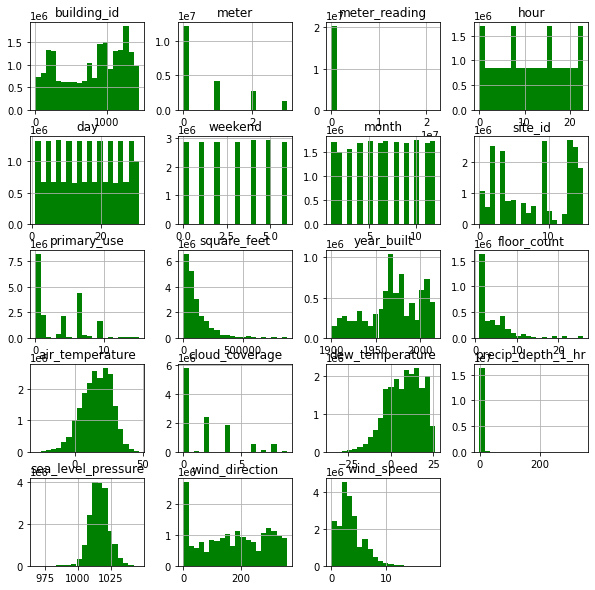

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

train_df.hist(figsize=(10,10),color="green",bins=20)

*When your input value is so small, using np.log1p to calculate, you will get the more accutrate result than np.log according to the interpretation from*

In [30]:
target = np.log1p(train_df["meter_reading"])
del train_df["meter_reading"]

In [31]:
train_df = train_df.drop(drop_cols + ["site_id", "floor_count"], axis = 1)

In [32]:
test_df = test_df.drop(drop_cols + ["site_id", "floor_count","row_id"], axis = 1)

In [33]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   building_id      int16  
 1   meter            int8   
 2   hour             int64  
 3   day              int64  
 4   weekend          int64  
 5   month            int64  
 6   primary_use      int8   
 7   square_feet      int32  
 8   year_built       float16
 9   air_temperature  float16
 10  cloud_coverage   float16
 11  dew_temperature  float16
dtypes: float16(4), int16(1), int32(1), int64(4), int8(2)
memory usage: 1.9 GB


In [34]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   building_id      int16  
 1   meter            int8   
 2   hour             int64  
 3   day              int64  
 4   weekend          int64  
 5   month            int64  
 6   primary_use      int8   
 7   square_feet      int32  
 8   year_built       float16
 9   air_temperature  float16
 10  cloud_coverage   float16
 11  dew_temperature  float16
dtypes: float16(4), int16(1), int32(1), int64(4), int8(2)
memory usage: 925.4 MB


In [35]:
gc.collect()

130

# Modelling

In [36]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

**Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.**

The general procedure is as follows:

    Shuffle the dataset randomly.
    
    Split the dataset into k groups
    
    For each unique group:
    
        Take the group as a hold out or test data set
        Take the remaining groups as a training data set
        Fit a model on the training set and evaluate it on the test set
        Retain the evaluation score and discard the model
        
    Summarize the skill of the model using the sample of model evaluation scores
    


**You can see that I'm not actually doing Kfold. I am skipping the first 4 folds and then just doing the last one so I am actually training on the first 80% of data and validating on the last 20%. I intended to do kfold and then realized it was too compute heavy and may possibly cause leakage.**

In [37]:
num_folds = 5
kf = KFold(n_splits = num_folds, shuffle = False, random_state = 42)
error = 0
models = []
for i, (train_index, val_index) in enumerate(kf.split(train_df)):
    if i + 1 < num_folds:
        continue
    print(train_index.max(), val_index.min())
    
    #Splitting The DF Into Train Test Split
    train_X = train_df[feat_cols].iloc[train_index]
    val_X = train_df[feat_cols].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    
    #Training The Model
    lgb_train = lgb.Dataset(train_X, train_y > 0)
    lgb_eval = lgb.Dataset(val_X, val_y > 0)
    params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'binary_logloss'},
            'learning_rate': 0.1,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq' : 5
            }
    gbm_class = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=20,
               verbose_eval = 20)
    
    #we did this so that we only consider positive vals and no dta leakage would be there
    lgb_train = lgb.Dataset(train_X[train_y > 0], train_y[train_y > 0]) 
    lgb_eval = lgb.Dataset(val_X[val_y > 0] , val_y[val_y > 0])
    params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'learning_rate': 0.5,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq' : 5
            }
    gbm_regress = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=20,
               verbose_eval = 20)
#     models.append(gbm)

    y_pred = (gbm_class.predict(val_X, num_iteration=gbm_class.best_iteration) > .5) *\
    (gbm_regress.predict(val_X, num_iteration=gbm_regress.best_iteration))
    error += np.sqrt(mean_squared_error(y_pred, (val_y)))/num_folds
    print(np.sqrt(mean_squared_error(y_pred, (val_y))))
    break
print(error)

16172879 16172880
[LightGBM] [Info] Number of positive: 14588424, number of negative: 1584456
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1161
[LightGBM] [Info] Number of data points in the train set: 16172880, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.902030 -> initscore=2.219987
[LightGBM] [Info] Start training from score 2.219987
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.180013	valid_1's binary_logloss: 0.179619
[40]	training's binary_logloss: 0.156394	valid_1's binary_logloss: 0.17163
[60]	training's binary_logloss: 0.1448	valid_1's binary_logloss: 0.171614
[80]	training's binary_logloss: 0.136717	valid_1's binary_logloss: 0.173615
Early stopping, best iteration is:
[63]	training's bi

In [38]:
sorted(zip(gbm_regress.feature_importance(), gbm_regress.feature_name()),reverse = True)

[(2404, 'building_id'),
 (2157, 'square_feet'),
 (1057, 'meter'),
 (851, 'year_built'),
 (790, 'primary_use'),
 (698, 'month'),
 (668, 'hour'),
 (545, 'air_temperature'),
 (323, 'dew_temperature'),
 (195, 'weekend'),
 (150, 'day'),
 (32, 'cloud_coverage')]

In [39]:
del train_df
gc.collect()

195

# Modifying For Submissions

*tqdm: Is Used For Displaying Horizontal Animated Bar*

*\ : Is For Regular Expression

In [40]:
from tqdm import tqdm
i=0
res=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(test_df.shape[0]/50000)))):
    
    res.append(np.expm1
               (
                   (gbm_class.predict
                    (test_df.iloc[i:i+step_size], num_iteration=gbm_class.best_iteration) > .5) *\
                       (gbm_regress.predict(test_df.iloc[i:i+step_size], num_iteration=gbm_regress.best_iteration))
               )
              )
    i+=step_size

100%|██████████| 834/834 [02:08<00:00,  6.49it/s]


In [41]:
del test_df

In [42]:
res = np.concatenate(res)
pd.DataFrame(res).describe()

,0
count,4.169760e+07
mean,3.127130e+02
std,1.971325e+03
min,-8.630281e-01
25%,1.711868e+01
50%,7.833743e+01
75%,2.534396e+02
max,2.501862e+05


In [43]:
print(res)

[  0.           0.           0.         ...   7.74453153 139.13351683
  20.30705139]


In [44]:
res.shape

(41697600,)

In [45]:
sub = pd.read_csv("energyCSV/sample_submission.csv")

In [46]:
sub["meter_reading"] = res

In [47]:
gc.collect()

235

In [48]:
#os.remove("./train_df.pkl")
#os.remove("./test_df.pkl")

In [49]:
sub

,row_id,meter_reading
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
...,...,...
41697595,41697595,19.091084
41697596,41697596,3.053052
41697597,41697597,7.744532
41697598,41697598,139.133517


In [50]:
#sub.to_csv("ignoreThese/submission.csv", index = False)